In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
from scipy.stats import truncnorm

In [2]:
def generate_timeseries(length, with_sin=False, sin_height_adjust=None):
    SIN_LENGTH_RATIO = 0.25
    timeseries = np.random.normal(0, 10, length)
    box = np.ones(10)/10
    timeseries = np.convolve(timeseries, box, mode='same')
    timeseries_info = (None, None, None) 

    if with_sin:
        sin_length = int(length*SIN_LENGTH_RATIO)
        t = np.linspace(0, 4*np.pi, sin_length)
        sine_wave = 2 * np.sin(t)
        sine_wave += sin_height_adjust
        patch_start = np.random.randint(0, length - len(t))
        patch_end = patch_start + len(t)
        timeseries[patch_start:patch_end] = sine_wave
        timeseries_info = (patch_start, patch_end, sin_height_adjust)

    return np.concatenate((timeseries, np.array(timeseries_info)))

In [3]:
def get_truncated_normal(len, mean=0.5, sd=.2, low=0, upp=1):
    return truncnorm(
        (low - mean) / sd, (upp - mean) / sd, loc=mean, scale=sd).rvs(len)

In [ ]:
def generate_dataset(ts_len, total, sin_n, randomize_sin_height=False):
    random_timeseries = [
        generate_timeseries(ts_len)
        for _ in range(total-sin_n)
    ]

    synthetic_error = get_truncated_normal(len=total-sin_n, mean=0.5, sd=0.1, low=0, upp=1)
    random_labels = np.c_[ synthetic_error, np.full((total-sin_n,), False) ]
    random_data = np.c_[ np.array(random_timeseries), random_labels]

    sin_height_normal = np.random.normal(0, 5, sin_n)
    
    sine_patch_timeseries = [
        generate_timeseries(ts_len, with_sin=True, sin_height_adjust=sin_height_normal[i]) 
        for i in range(sin_n)
    ]

    sine_synth_error = get_truncated_normal(len=sin_n, mean=0.9, sd=0.05, low=0, upp=1)
    sine_labels = np.c_[ sine_synth_error, np.full((sin_n,), True) ]
    sine_data = np.c_[ np.array(sine_patch_timeseries), sine_labels ] 

    full_data = np.r_[ random_data, sine_data ]
    columns = list(range(0, ts_len)) + ['sin_x0', 'sin_x1', 'sin_y', 'error', 'label']
    return pd.DataFrame(full_data, columns=columns)

In [5]:
def plot_random_series_helper(df):
    random_row = df.sample()
    datapoints = random_row.drop(columns=['sin_x0', 'sin_x1', 'sin_y', 'label', 'error'])
    plt.plot(datapoints.values.flatten())
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.show()

In [6]:
def plot_error_distributions(df):
    bins = np.linspace(0, 1, 50)
    plt.hist(df[df['label']==0]['error'], bins, alpha=0.5, label='sin=false')
    plt.hist(df[df['label']==1]['error'], bins, alpha=0.5, label='sin=true')
    plt.legend(loc='upper right')
    plt.show()

### FIXED-Y, NO NOISE
200 series, half with sin

In [7]:
df = generate_dataset(ts_len=150, total=500, sin_n=250)

In [8]:
df[df.label==1].head(10)

,0,1,2,3,4,5,6,7,8,9,...,145,146,147,148,149,sin_x0,sin_x1,sin_y,error,label
250,-3.07884,-4.55331,-5.32804,-2.96906,-4.61048,-5.12969,-3.91496,-3.40837,-1.82816,-0.444758,...,0.0476688,-1.69647,-1.47412,-0.715577,-1.21978,88,125,3.29004,0.926576,1
251,-2.91512,-3.73113,-3.74684,-3.31769,-1.80502,-1.53205,-1.30818,-1.09013,-0.825334,-2.92462,...,-2.14063,-2.06805,-2.56378,-3.38091,-2.71728,55,92,1.35251,0.904513,1
252,-0.881781,-0.407544,-0.395891,-1.40471,-1.72426,-2.37163,-2.61987,-3.18631,-2.12164,-2.48617,...,1.93111,2.21084,2.99081,2.45427,2.42543,61,98,0.340516,0.951288,1
253,0.120952,-1.13919,-0.765736,-0.541019,-1.02299,-0.403943,0.483696,-0.817341,-0.367803,-0.362684,...,2.10001,1.88478,2.33006,3.25898,2.75658,76,113,-10.2548,0.871308,1
254,-2.49253,-0.717203,1.52866,0.123919,2.55772,3.43192,2.79104,4.88335,5.65077,5.3307,...,0.603411,1.21193,1.67889,1.95442,2.20837,15,52,4.95347,0.912537,1
255,-3.88358,-3.73402,-1.50491,-2.59358,-2.7704,-2.50024,-3.06143,-1.47612,0.040403,2.03013,...,0.833718,0.318565,-0.159764,1.08389,1.58231,65,102,-2.75731,0.936383,1
256,-1.12725,-1.2091,-1.39667,-0.917665,-0.287363,0.396677,0.998212,1.44469,1.68225,1.68225,...,2.87959,4.90386,6.07156,4.56592,4.56701,4,41,-0.287363,0.874193,1
257,2.10128,1.28176,2.73416,2.76857,2.55119,2.58907,3.29756,2.80223,3.25557,5.18154,...,-0.104179,-2.13464,-2.1372,-1.23532,-2.48673,101,138,2.11028,0.905682,1
258,-2.48647,-2.266,-2.28673,-2.31512,-4.31608,-5.19031,-4.78284,-4.12848,-5.80757,-5.81544,...,-1.16069,-0.000929257,1.64065,1.26627,1.39725,58,95,-11.3422,0.919596,1
259,1.51247,0.422013,0.253362,0.173094,0.321928,0.826765,1.31823,2.27487,3.36147,3.38478,...,1.70234,3.01088,3.32839,1.81968,0.251086,48,85,10.3384,0.850361,1


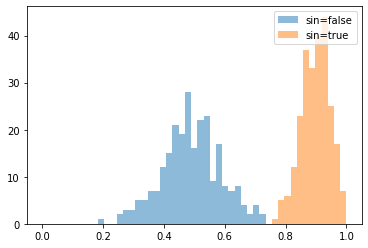

In [9]:
plot_error_distributions(df)

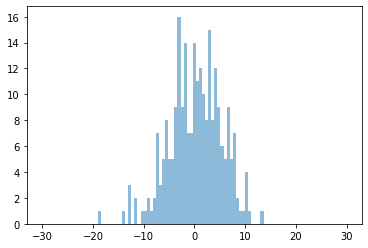

In [10]:
bins = np.linspace(-30, 30, 100)
_ = plt.hist(df[df['label']==1].sin_y, bins, alpha=0.5)

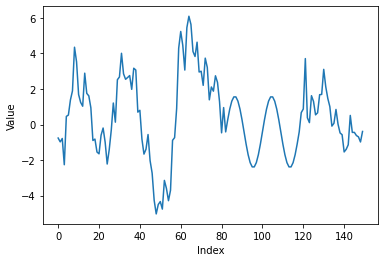

In [16]:
plot_random_series_helper(df=df[df['label']==1])

In [ ]:
df.to_csv('./sin_synth/SIN_NORMAL_500_v3.csv', index=False)